In [2]:
import numpy as np
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.risk as risk
import mlgrad.avragg as avragg
# import mlgrad.gd as gd
import mlgrad.regnorm as regnorm
import mlgrad.weights as weights
from mlgrad.utils import array_exclude_outliers

import mlgrad.regr as regr

from mlgrad import averager_it, averager_fg, fg, erm_fg, sg, erm_sg, irgd, erm_irgd, erisk, mrisk

#import sklearn.linear_model as sklm

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-ticks'])

import sys
print(sys.version)

3.9.2 (default, Feb 28 2021, 17:03:44) 
[GCC 10.2.1 20210110]


In [3]:
df = pd.read_csv("data/telef.csv", sep=',')

In [4]:
len(df)

24

In [5]:
df

,id,Year,Calls
0,1,50,0.44
1,2,51,0.47
2,3,52,0.47
3,4,53,0.59
4,5,54,0.66
5,6,55,0.73
6,7,56,0.81
7,8,57,0.88
8,9,58,1.06
9,10,59,1.20


In [9]:
X = df["Year"].values
Y = df["Calls"].values

X = np.array(X, 'd')
Y = np.array(Y, 'd')
X -= 50

# X = np.log(X)
# Y = np.log(Y)

# x_min, x_max = X.min(), X.max()
# X = (X - x_min) / (x_max - x_min)
# y_min, y_max = Y.min(), Y.max()
# Y = (Y - y_min) / (y_max - y_min)

Xs = X.reshape((-1,1))

X0 = np.linspace(X.min(), X.max(), 20)

In [10]:
from sklearn.preprocessing import scale

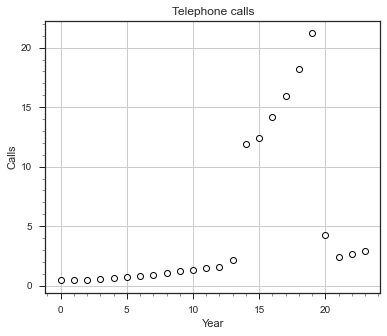

In [11]:
plt.figure(figsize=(6.0, 5.0))
plt.scatter(X, Y, s=36, c='w', edgecolors='k', linewidths=1.)
plt.title('Telephone calls')
plt.minorticks_on()
plt.grid(1)
plt.xlabel('Year')
plt.ylabel('Calls')
# plt.xlim(-0.9, 0.6)
# plt.ylim(-2.5, 2.0)
plt.show()

In [12]:
loss_func_sq = loss.ErrorLoss(func.Square())
# loss_func_rsq = loss.RelativeErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())

In [13]:
sqr_norm = regnorm.SquareNorm()

In [14]:
def curve_fit_and_errors(alg):
    err = np.abs(Y - alg.risk.model.evaluate_all(Xs))
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.title('Fit curve')
    plt.plot(alg.lvals)
    plt.xlabel('step')
    plt.ylabel('mean of errors')
    plt.minorticks_on()
    plt.subplot(1,2,2)
    plt.title('Errors')
    plt.plot(sorted(err), marker='s', markersize='6')
    plt.minorticks_on()
    plt.xlabel('error rank')
    plt.ylabel('error value')
    plt.show()
    return err

In [15]:
mod_ls = model.LinearModel(1)
mod_ls.init()

[0.99122764 0.46178158] 2


K=1500 param=[-0.79834593  0.50413484]


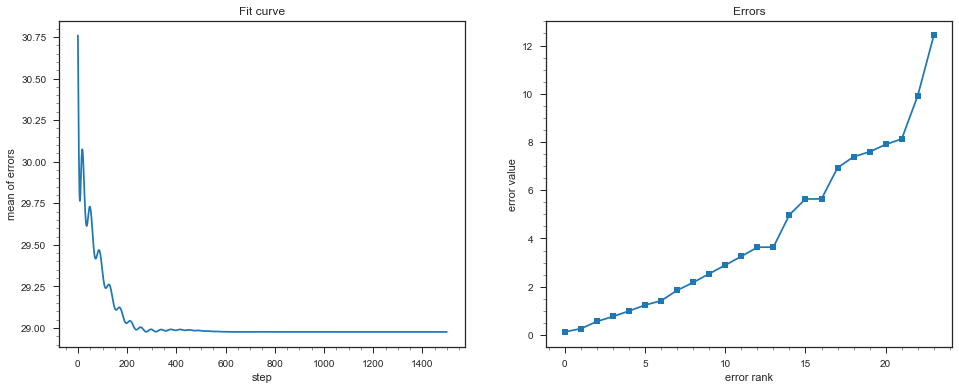

In [16]:
alg_ls = regr.regression(Xs, Y, mod_ls, n_iter=1500, h=0.01, verbose=1)
err_ls = curve_fit_and_errors(alg_ls)

In [17]:
mod_m_irls = model.LinearModel(1)
mod_m_irls.init()

[0.69706628 0.85257262] 2


K=70 param=[-0.03135496  0.12415154]


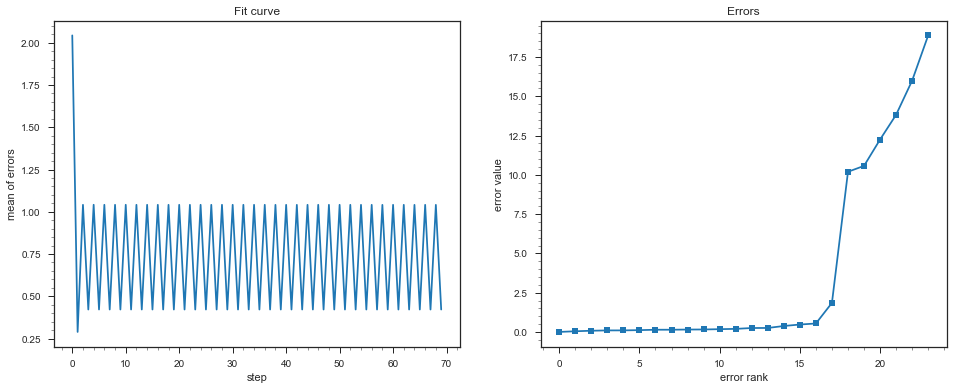

In [18]:
avg_m_irls = regr.averaging_function('M', rhofunc=func.Quantile_Sqrt(0.7, 0.001))
alg_m_irls = regr.m_regression_irls(Xs, Y, mod_m_irls, avrfunc=avg_m_irls, h=0.001, n_iter2=70, verbose=1)
err_m_irls = curve_fit_and_errors(alg_m_irls)

In [19]:
mod_wm_irls = model.LinearModel(1)
mod_wm_irls.init()

[0.17029636 0.63027314] 2


K=70 param=[0.28957892 0.10917307]


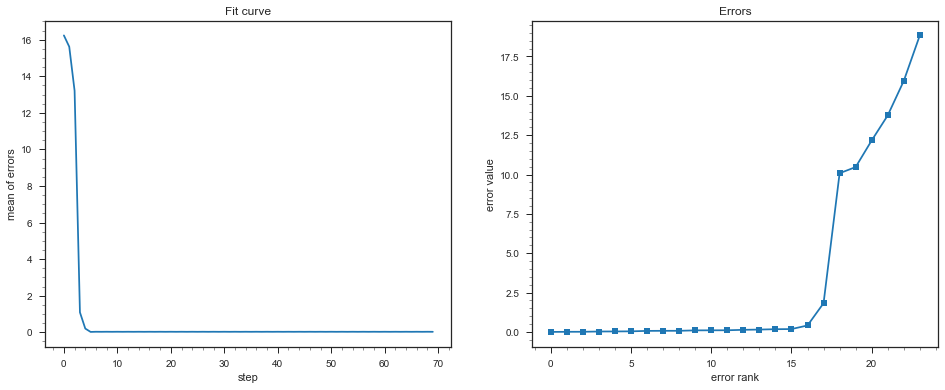

In [20]:
avg_wm_irls = regr.averaging_function('WM', rhofunc=func.Sqrt(0.001), alpha=0.66)
alg_wm_irls = regr.m_regression_irls(Xs, Y, mod_wm_irls, avrfunc=avg_wm_irls, h=0.001, n_iter2=70, verbose=1)
err_wm_irls = curve_fit_and_errors(alg_wm_irls)

In [21]:
mod_swm_irls = model.LinearModel(1)
mod_swm_irls.init()

[0.51763877 0.63162814] 2


K=21 param=[0.30916031 0.1078037 ]


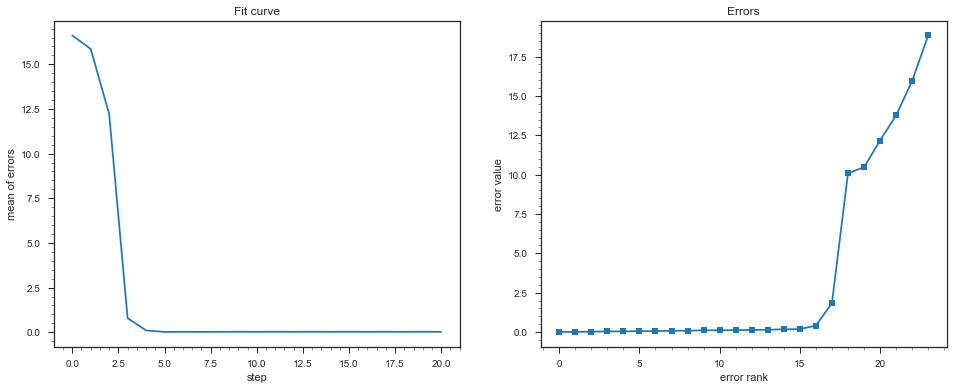

In [22]:
avg_swm_irls = regr.averaging_function('SWM', rhofunc=func.Sqrt(0.001), alpha=0.66)
alg_swm_irls = regr.m_regression_irls(Xs, Y, mod_swm_irls, avrfunc=avg_swm_irls, h=0.001, tol=1.0e-8, verbose=1)
err_swm_irls = curve_fit_and_errors(alg_swm_irls)

In [23]:
# Err = np.abs(Y - mod2.evaluate_all(Xs))

# X1, X1_ = array_exclude_outliers(X, Err, 7) 
# Y1, Y1_ = array_exclude_outliers(Y, Err, 7) 
# X1s = X1.reshape(-1,1)

In [31]:
mod_r_irls = model.LinearModel(1)
mod_r_irls.init()

[0.17673238 0.45390383] 2


K=3 param=[0.23856994 0.11571498]


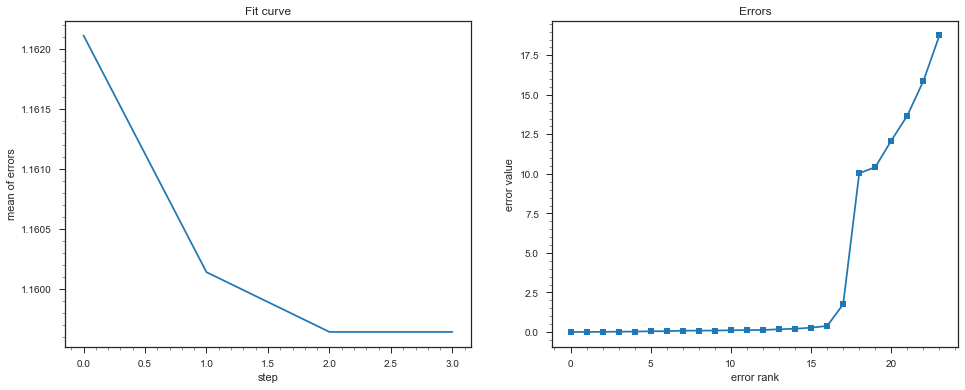

In [32]:
alg_r_irls = regr.r_regression_irls(Xs, Y, mod_r_irls, rhofunc=func.Sqrt(0.001), h=0.001, n_iter2=70, verbose=1)
err_r_irls = curve_fit_and_errors(alg_r_irls)

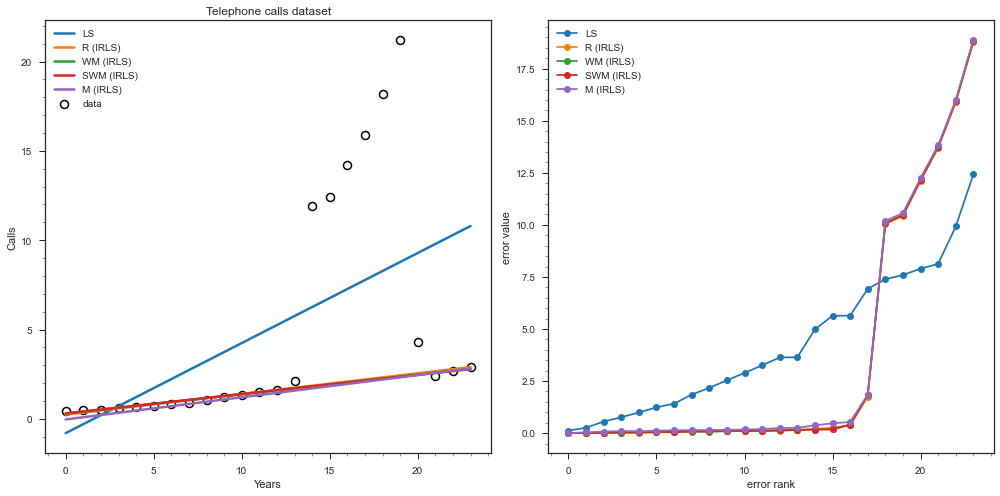

In [36]:
plt.figure(figsize=(14.0, 7.0))
plt.subplot(1,2,1)
plt.title('Telephone calls dataset')
plt.scatter(X, Y, s=64, c='w', edgecolors='k', linewidths=1.5, label='data')
plt.plot(X0, mod_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'LS')
plt.plot(X0, mod_r_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'R (IRLS)')
plt.plot(X0, mod_wm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (IRLS)')
# plt.plot(X0, mod_wm_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (LS)')
plt.plot(X0, mod_swm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'SWM (IRLS)')
plt.plot(X0, mod_m_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'M (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.xlabel('Years')
plt.ylabel('Calls')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(sorted(np.abs(Y - mod_ls.evaluate_all(Xs))), marker='o', markersize=7, label=r'LS')
plt.plot(sorted(np.abs(Y - mod_r_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'R (IRLS)')
plt.plot(sorted(np.abs(Y - mod_wm_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'WM (IRLS)')
# plt.plot(sorted(np.abs(Y - mod_wm_ls.evaluate_all(Xs))), marker='o', markersize=7, label=r'WM (LS)')
plt.plot(sorted(np.abs(Y - mod_swm_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'SWM (IRLS)')
plt.plot(sorted(np.abs(Y - mod_m_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'M (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.ylabel('error value')
plt.xlabel('error rank')
# plt.ylim(-0.1, 4.5)
# plt.xlim(-1, 48)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [27]:
(len(Y)-8)/len(Y)

0.6666666666666666